In [1]:
import pandas as pd 

df = pd.read_excel('satisfaction xl.xlsx')
df.head()

,month_id,survey_date,subs_no,brand_medallia,survey_type,macro_journey,micro_journey,brand,brand_category,category,...,trx_mov1,trx_mov2,trx_mov3,trx_mov4,trx_mov5,rpt_mov1,rpt_mov2,rpt_mov3,rpt_mov4,rpt_mov5
0,202412,2024-12-18,52940263,XL PREPAID,XL_Channel_Apps Performance_Apps Interface,Apps Performance,Apps Interface,XL,XL PREPAID,Touchpoint,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202412,2024-12-05,47772513,XL PREPAID,XL_Channel_Manage My Usage_Quota Information,Manage My Usage,Quota Information,XL,XL PREPAID,Touchpoint,...,0.0,1.0,-3.0,-2.0,-2.0,-28517.717718,34545.795796,5346.396396,11374.474474,39892.192192
2,202412,2024-12-18,2064752097,XL PREPAID,XL_Product_Buy Package_Ease to Find Package,Buy Package,Easy to find packet,XL,XL PREPAID,Product,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-43819.819820,-61351.351351,NaN
3,202412,2024-12-11,55253504,XL PREPAID,XL_Channel_Manage My Usage_Quota Information,Manage My Usage,Quota Information,XL,XL PREPAID,Touchpoint,...,0.0,1.0,-1.0,0.0,0.0,-7522.522523,6452.702703,-2477.477477,-3547.297297,3975.225225
4,202412,2024-12-07,1388265608,XL PREPAID,XL_Channel_Apps Performance_Apps Interface,Apps Performance,Apps Interface,XL,XL PREPAID,Touchpoint,...,NaN,0.0,0.0,NaN,0.0,NaN,-1857.657658,-5123.423423,NaN,-6981.081081


### Data Preprocessing

In [38]:
columns_to_drop = ['month_id', 'survey_date', 'subs_no', 'reason_for_score', 'survey_type', 'dom_cdmainid']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

In [2]:
# Handling missing values
df.fillna({
    'arpu_segment': df['arpu_segment'].mode()[0],
    'tenure_cat': df['tenure_cat'].mode()[0],
    'cx_centric_flag': df['cx_centric_flag'].mode()[0],
    'total_incident_all': df['total_incident_all'].fillna(0),
    'complaint_sum': df['complaint_sum'].fillna(0)
}, inplace=True)

In [3]:
# Convert numerical categorical features into categorical format
df['total_incident_all'] = df['total_incident_all'].astype(str)
df['complaint_sum'] = df['complaint_sum'].astype(str)

In [4]:
# Handle NaN values in ARPU movement columns and replace with 0
darpu_cols = ['arpu_mov1', 'arpu_mov2', 'arpu_mov3', 'arpu_mov4', 'arpu_mov5']
df[darpu_cols] = df[darpu_cols].fillna(0)

In [5]:
# Ensure ARPU movement values are binned for better readability
def bin_arpu_movement(row):
    movements = row[darpu_cols]
    if movements.isna().all():
        return 'All NaN'
    elif movements.sum() == 0:
        return 'No Movement'
    else:
        return 'Has Movement'

df['arpu_movement'] = df.apply(bin_arpu_movement, axis=1)

Jika jumlah dari semua kolom ARPU movement adalah 0:
Fungsi akan mengembalikan nilai 'No Movement', artinya bahwa tidak ada perubahan ARPU yang terjadi.

Jika ada pergerakan (jumlahnya tidak 0 dan ada nilai):
Fungsi akan mengembalikan nilai 'Has Movement', artinya bahwa terdapat perubahan ARPU.

In [14]:
# Convert ARPU movement columns into one categorical feature
# df['arpu_movement'] = df[['arpu_mov1', 'arpu_mov2', 'arpu_mov3', 'arpu_mov4', 'arpu_mov5']].astype(str).agg('-'.join, axis=1)

In [6]:
# Adjust column mappings 
categorical_vars_adjusted = {
    'ARPU category': 'arpu_segment',
    'Tenure segment': 'tenure_cat',
    'CX centric flag': 'cx_centric_flag',
    'Incident': 'total_incident_all',
    'Complaint': 'complaint_sum',
    'ARPU movement': 'arpu_movement'
}

### EDA

Arti Lagenda:
0.0 = Happy
1.0 = Unhappy

- add proporsi unhappy terhadap keseluruhan arpu
- add proporsi unhappy terhadap keseluruhan tenure segment
- incident all, incident catastrophe, incident critical, duration incident di eksplore lagi
- inquery di eksplor lagi
- data numerik atau kontinu coba di average

In [20]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("whitegrid")

# # Create count plots for each categorical variable
# for target in ['unhappy_flag1', 'unhappy_flag2']:
#     for label, col in categorical_vars_adjusted.items():
#         plt.figure(figsize=(10, 5))
#         sns.countplot(data=df, x=col, hue=target, palette="coolwarm", order=df[col].value_counts().index[:10])  # Limiting to top 10 categories
#         plt.xticks(rotation=45)
#         plt.title(f'Distribution of {target} by {label}')
#         plt.xlabel(label)
#         plt.ylabel('Count')
#         plt.legend(title=target)
#         plt.show()

In [29]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("whitegrid")

# # Create count plots for each categorical variable
# for target in ['unhappy_flag1', 'unhappy_flag2']:
#     for label, col in categorical_vars_adjusted.items():
#         plt.figure(figsize=(10, 5))
#         ax = sns.countplot(data=df, x=col, hue=target, palette="coolwarm", order=df[col].value_counts().index[:10])  # Limiting to top 10 categories

#         # Add percentages for ARPU category and Tenure segment
#         if col in ['arpu_segment', 'tenure_cat']:
#             totals = df[col].value_counts()
#             for p in ax.patches:
#                 x_position = p.get_x() + p.get_width() / 2.0
#                 category = p.get_x() if isinstance(p.get_x(), str) else df[col].value_counts().index[int(p.get_x())]
#                 height = p.get_height()
#                 if height > 0 and category in totals.index:
#                     percentage = (height / totals[category]) * 100
#                     ax.annotate(f'{percentage:.1f}%', (x_position, height), ha='center', va='bottom', fontsize=10, color='black')

#         plt.xticks(rotation=45)
#         plt.title(f'Distribution of {target} by {label}')
#         plt.xlabel(label)
#         plt.ylabel('Count')
#         plt.legend(title=target)
#         plt.show()

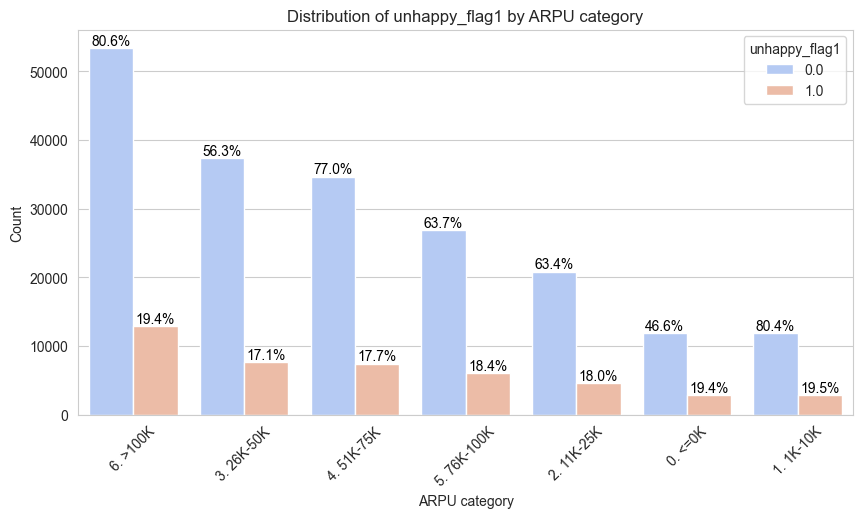

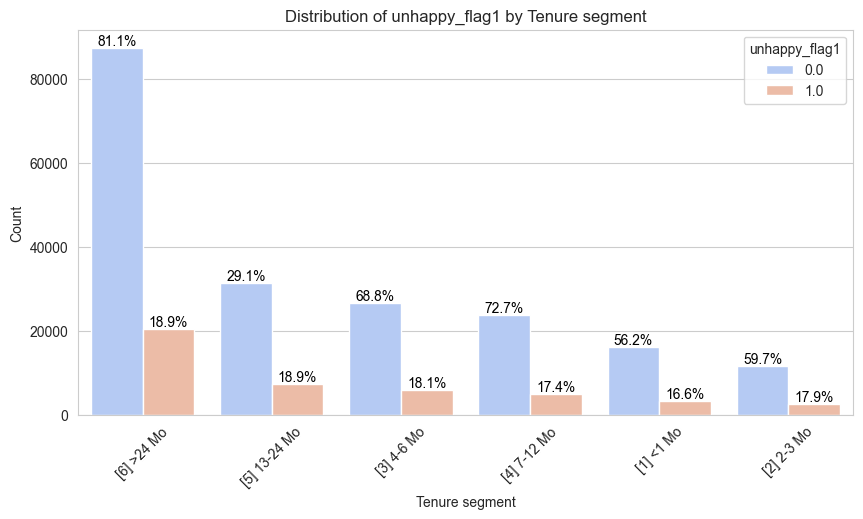

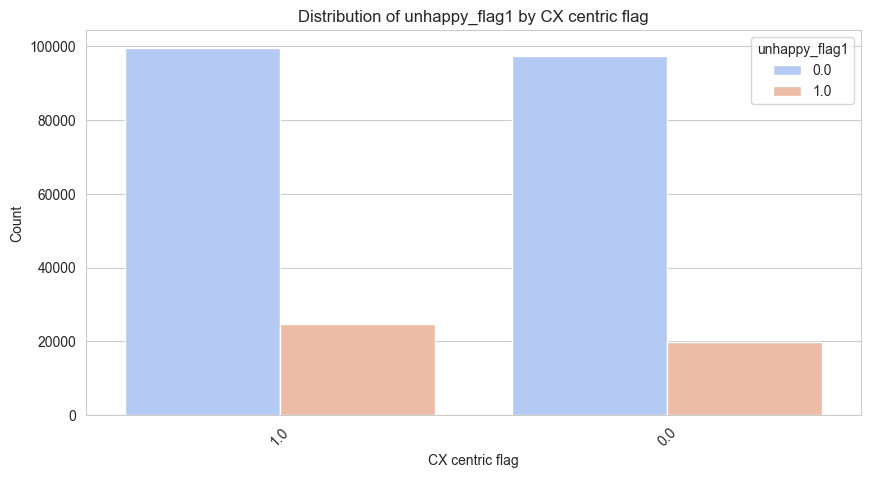

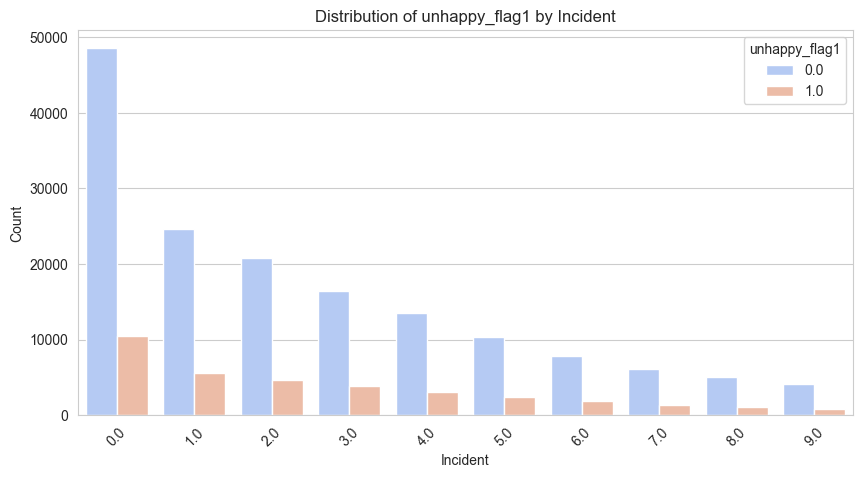

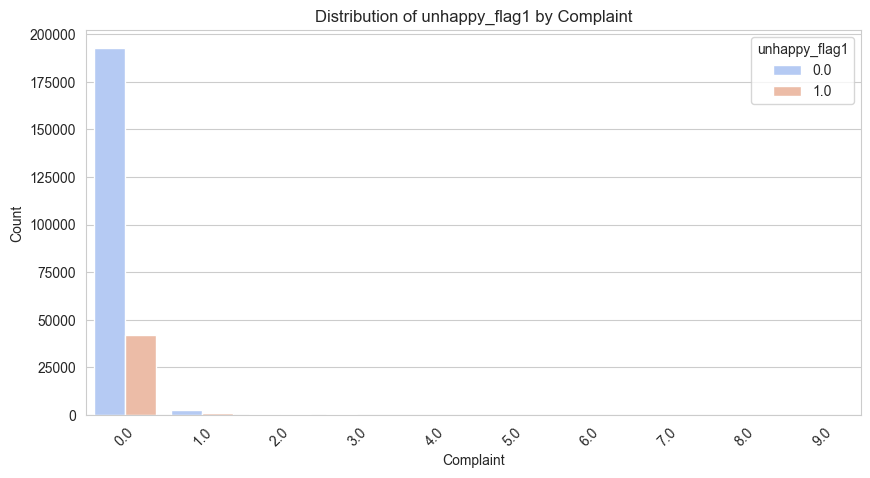

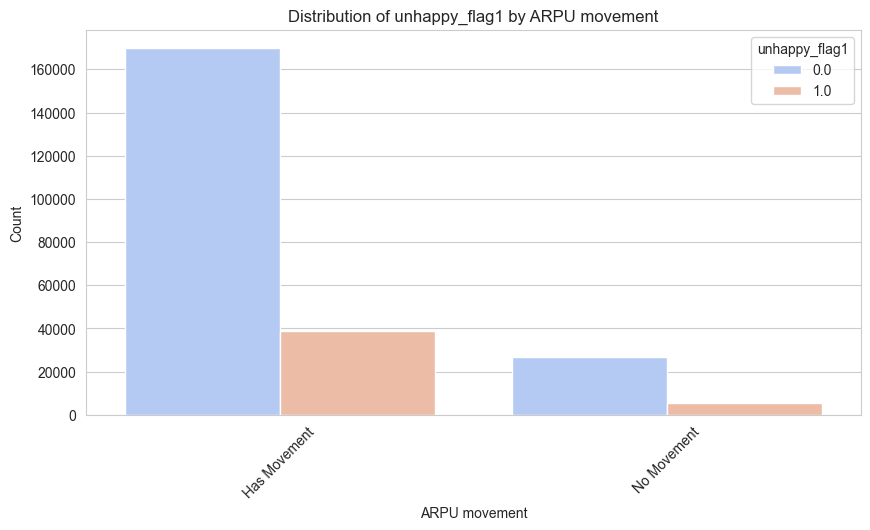

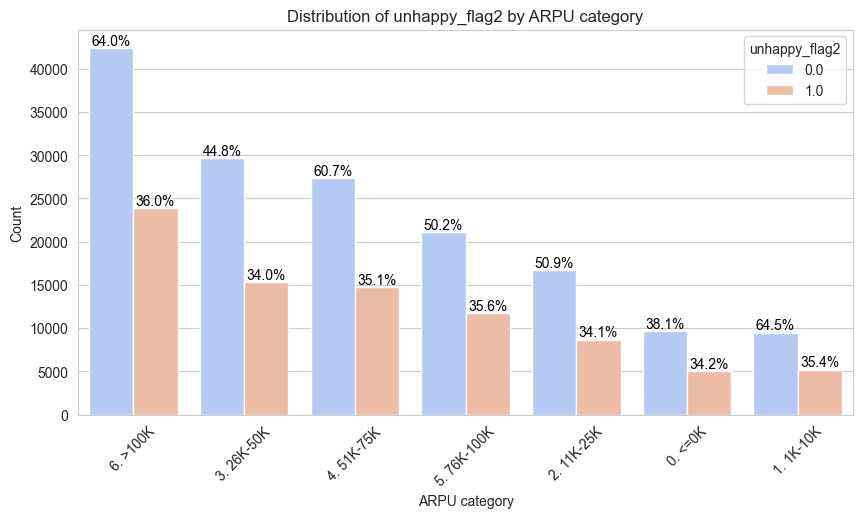

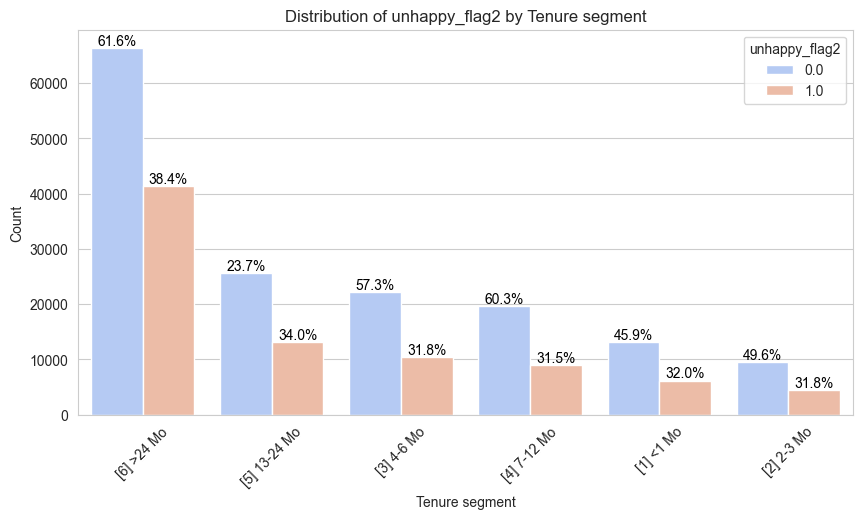

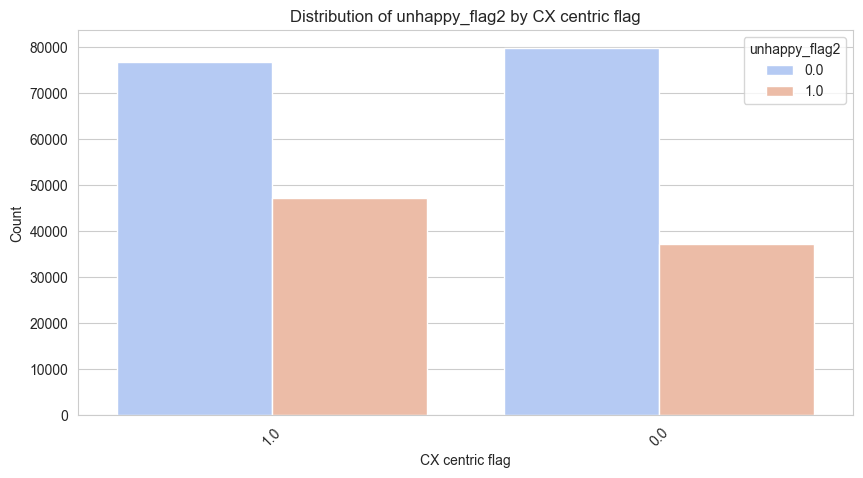

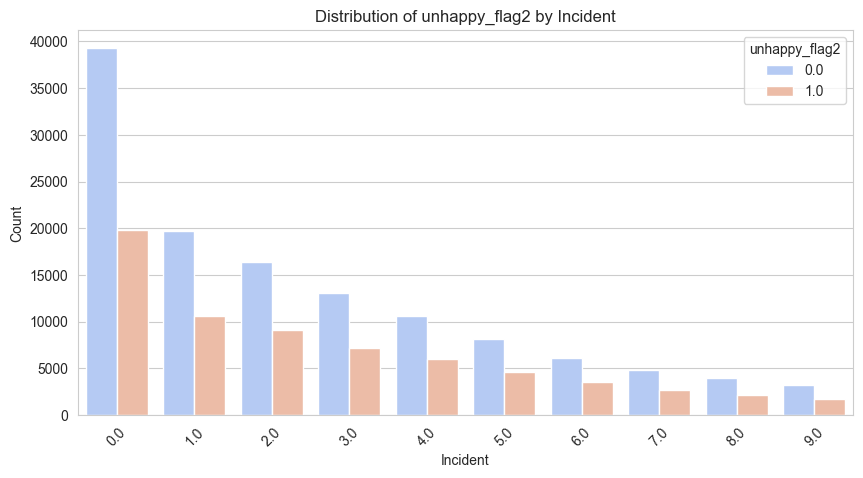

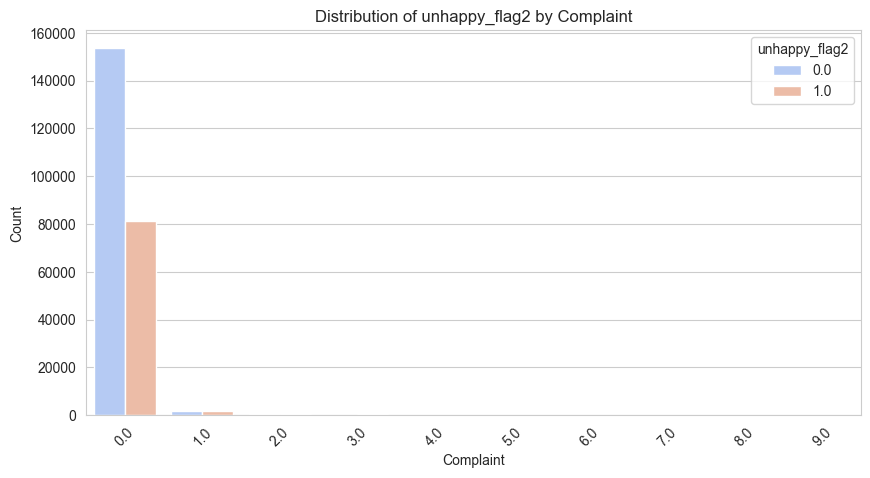

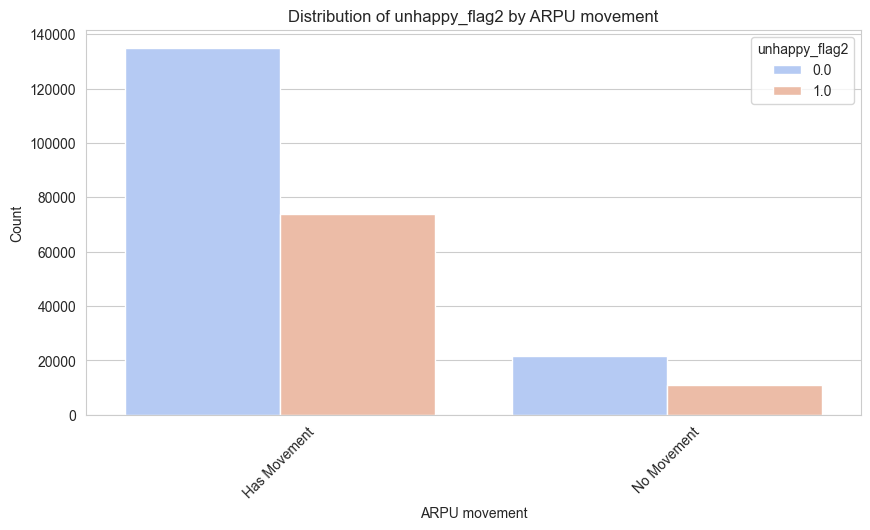

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# Data Preprocessing
# Handling missing values by filling with mode or mean where appropriate
df.fillna({
    'arpu_segment': df['arpu_segment'].mode()[0],
    'tenure_cat': df['tenure_cat'].mode()[0],
    'cx_centric_flag': df['cx_centric_flag'].mode()[0],
    'total_incident_all': df['total_incident_all'].fillna(0),
    'total_incident_critical': df['total_incident_critical'].fillna(0),
    'total_incident_catash': df['total_incident_catash'].fillna(0),
    'duration_all': df['duration_all'].fillna(df['duration_all'].mean()),
    'duration_critical': df['duration_critical'].fillna(df['duration_critical'].mean()),
    'duration_catash': df['duration_catash'].fillna(df['duration_catash'].mean()),
    'complaint_sum': df['complaint_sum'].fillna(0),
    'inquiry': df['inquiries_sum'].fillna(0)
}, inplace=True)

# Convert numerical categorical features into categorical format
df['total_incident_all'] = df['total_incident_all'].astype(str)
df['complaint_sum'] = df['complaint_sum'].astype(str)

# Handle NaN values in ARPU movement columns and replace with 0
darpu_cols = ['arpu_mov1', 'arpu_mov2', 'arpu_mov3', 'arpu_mov4', 'arpu_mov5']
df[darpu_cols] = df[darpu_cols].fillna(0)

# Ensure ARPU movement values are binned for better readability
def bin_arpu_movement(row):
    movements = row[darpu_cols]
    if movements.isna().all():
        return 'All NaN'
    elif movements.sum() == 0:
        return 'No Movement'
    else:
        return 'Has Movement'

df['arpu_movement'] = df.apply(bin_arpu_movement, axis=1)

# Adjust column mappings based on dataset
categorical_vars_adjusted = {
    'ARPU category': 'arpu_segment',
    'Tenure segment': 'tenure_cat',
    'CX centric flag': 'cx_centric_flag',
    'Incident': 'total_incident_all',
    'Complaint': 'complaint_sum',
    'ARPU movement': 'arpu_movement'
}

# Set up the plotting style
sns.set_style("whitegrid")

# Explore incident-related variables and inquiry
incident_vars = ['total_incident_all', 'total_incident_critical', 'total_incident_catash', 'duration_all', 'duration_critical', 'duration_catash', 'inquiries_sum']

# Create count plots for each categorical variable
for target in ['unhappy_flag1', 'unhappy_flag2']:
    for label, col in categorical_vars_adjusted.items():
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x=col, hue=target, palette="coolwarm", order=df[col].value_counts().index[:10])  # Limiting to top 10 categories

        # Add percentages for ARPU category and Tenure segment
        if col in ['arpu_segment', 'tenure_cat']:
            totals = df[col].value_counts()
            for p in ax.patches:
                x_position = p.get_x() + p.get_width() / 2.0
                category = p.get_x() if isinstance(p.get_x(), str) else df[col].value_counts().index[int(p.get_x())]
                height = p.get_height()
                if height > 0 and category in totals.index:
                    percentage = (height / totals[category]) * 100
                    ax.annotate(f'{percentage:.1f}%', (x_position, height), ha='center', va='bottom', fontsize=10, color='black')

        plt.xticks(rotation=45)
        plt.title(f'Distribution of {target} by {label}')
        plt.xlabel(label)
        plt.ylabel('Count')
        plt.legend(title=target)
        plt.show()

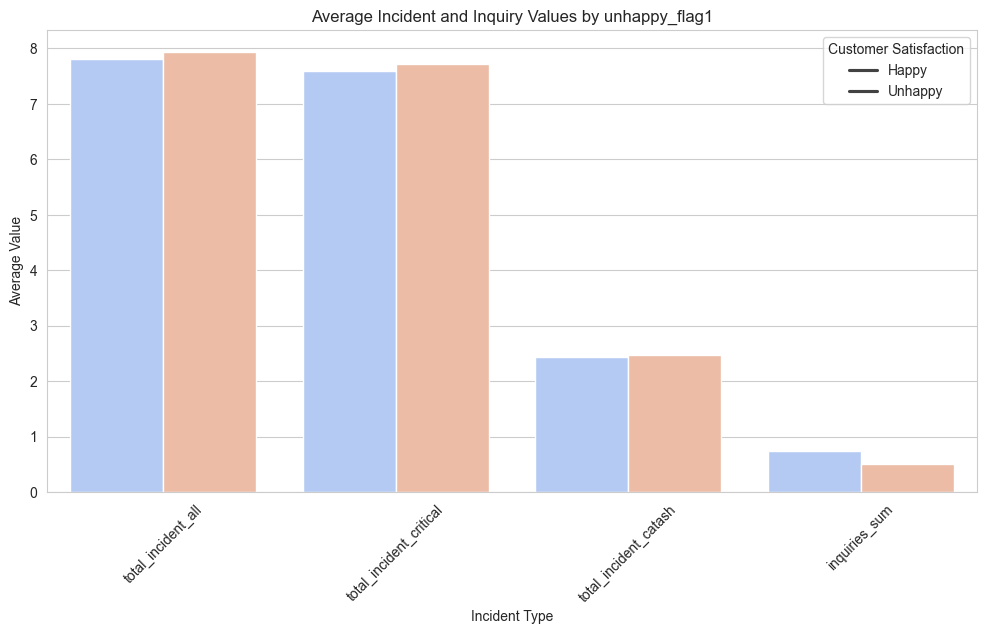

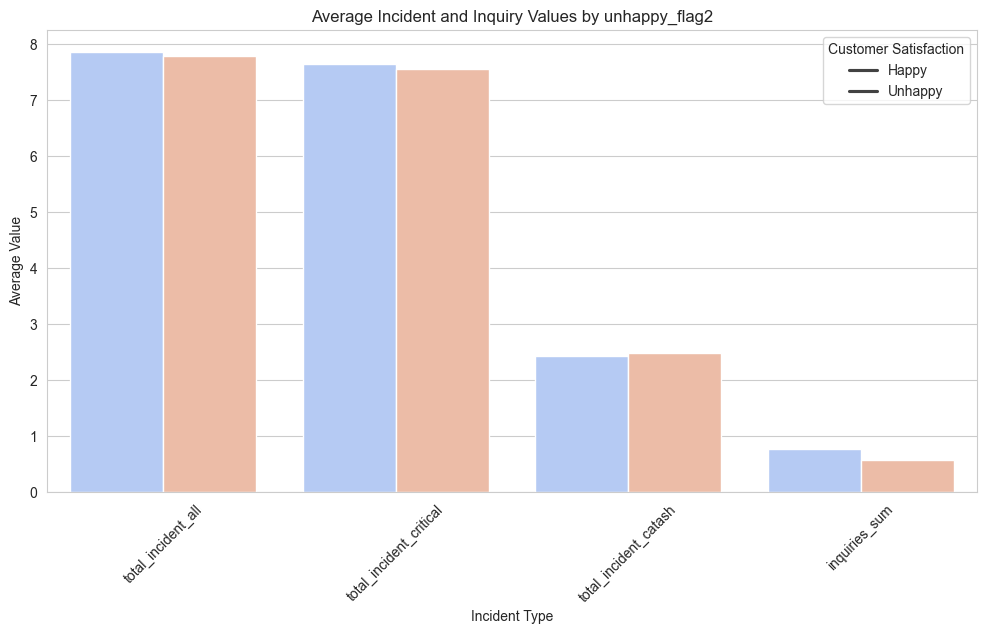

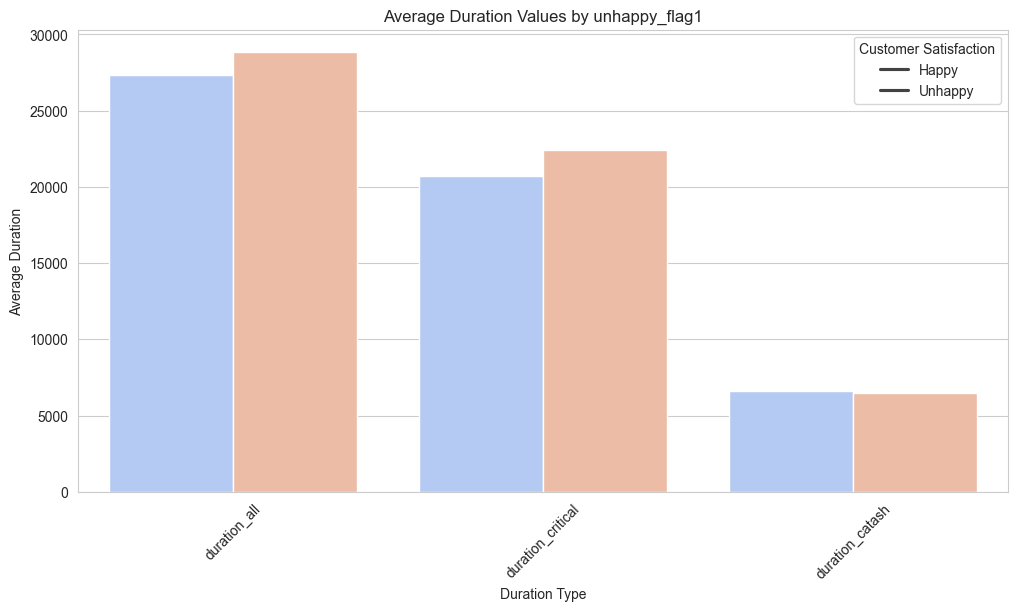

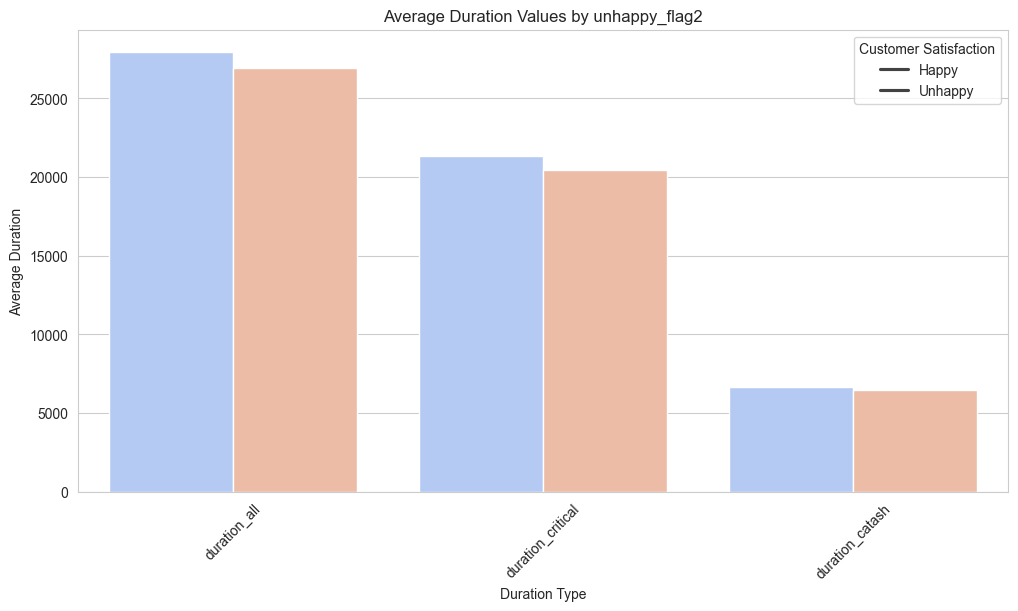

In [28]:
# Separate barplot for different incident and duration variables
incident_vars_main = ['total_incident_all', 'total_incident_critical', 'total_incident_catash', 'inquiries_sum']
duration_vars = ['duration_all', 'duration_critical', 'duration_catash']

# Plot for main incident variables
for target in ['unhappy_flag1', 'unhappy_flag2']:
    plt.figure(figsize=(12, 6))
    data = df.groupby(target)[incident_vars_main].apply(lambda x: x.astype(float).mean()).reset_index()
    data_melted = data.melt(id_vars=target, var_name='Incident Type', value_name='Average Value')
    ax = sns.barplot(data=data_melted, x='Incident Type', y='Average Value', hue=target, palette='coolwarm')
    plt.title(f'Average Incident and Inquiry Values by {target}')
    plt.xlabel('Incident Type')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.legend(title='Customer Satisfaction', labels=['Happy', 'Unhappy'])
    plt.show()

# Plot for duration-related variables
for target in ['unhappy_flag1', 'unhappy_flag2']:
    plt.figure(figsize=(12, 6))
    data = df.groupby(target)[duration_vars].apply(lambda x: x.astype(float).mean()).reset_index()
    data_melted = data.melt(id_vars=target, var_name='Duration Type', value_name='Average Duration')
    ax = sns.barplot(data=data_melted, x='Duration Type', y='Average Duration', hue=target, palette='coolwarm')
    plt.title(f'Average Duration Values by {target}')
    plt.xlabel('Duration Type')
    plt.ylabel('Average Duration')
    plt.xticks(rotation=45)
    plt.legend(title='Customer Satisfaction', labels=['Happy', 'Unhappy'])
    plt.show()

In [49]:
# Calculate averages for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
average_table = df.groupby(['unhappy_flag1'])[numeric_cols].mean().T
average_table.columns = ['Class 0', 'Class 1']

# Apply color formatting 
def highlight_extremes(row):
    styles = []
    max_val = row.max()
    min_val = row.min()
    for val in row:
        if val == max_val:
            styles.append('color: red;')
        elif val == min_val:
            styles.append('color: green;')
        else:
            styles.append('')
    return styles

# Apply formatting 
formatted_table = average_table.style.apply(highlight_extremes, axis=1)
formatted_table

,Class 0,Class 1
main_score,9.406136,3.537712
unhappy_flag1,0.000000,1.000000
unhappy_flag2,0.204608,1.000000
arpu_m0,76986.251428,79054.345134
arpu_m1,66092.286694,68576.816508
arpu_m2,62041.264342,65821.665019
arpu_m3,64659.574319,68542.039559
arpu_90d_m0,136402.437360,141169.861809
arpu_90d_m1,65277.581713,68343.425965
arpu_90d_m2,64194.946885,67476.747806


In [54]:
# Pastikan grouped_numeric sudah dihitung sebelumnya
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Hitung rata-rata setiap variabel numerik berdasarkan flag unhappy_flag1
grouped_numeric = df.groupby('unhappy_flag1')[numeric_cols].mean().T
grouped_numeric.columns = ['Class 0', 'Class 1']

# Hitung perbedaan absolut antara Class 0 dan Class 1
difference = (grouped_numeric['Class 1'] - grouped_numeric['Class 0']).abs()

# Hitung threshold
threshold = difference.mean() + difference.std()

# Filter variabel yang memiliki selisih signifikan
significant_difference = difference[difference > threshold]

# Tampilkan hasilnya
print("Variables with significant differences between Class 0 and Class 1:")
print(significant_difference.sort_values(ascending=False))

Variables with significant differences between Class 0 and Class 1:
arpu_90d_m0         4767.424449
arpu_m3             3882.465240
arpu_m2             3780.400677
arpu_90d_m2         3281.800921
rev_m2              3277.504158
rev_m3              3167.918819
arpu_90d_m3         3091.730613
arpu_90d_m1         3065.844252
rev_m0              2577.781023
arpu_m1             2484.529814
mrev_data_90d_m2    2480.370976
mrev_90d_m2         2470.533352
mrev_data_90d_m3    2421.771999
mrev_90d_m3         2407.515452
dom_price           2375.606248
rev_m1              2196.190346
arpu_m0             2068.093707
mrev_data_90d_m1    2004.662900
mrev_90d_m1         1998.694430
dtype: float64


In [51]:
# Calculate averages for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
average_table2 = df.groupby(['unhappy_flag2'])[numeric_cols].mean().T
average_table2.columns = ['Class 0', 'Class 1']

# Apply color formatting 
def highlight_extremes(row):
    styles = []
    max_val = row.max()
    min_val = row.min()
    for val in row:
        if val == max_val:
            styles.append('color: red;')
        elif val == min_val:
            styles.append('color: green;')
        else:
            styles.append('')
    return styles

# Apply formatting f
formatted_table2 = average_table2.style.apply(highlight_extremes, axis=1)
formatted_table2

,Class 0,Class 1
main_score,9.859451,5.492019
unhappy_flag1,0.000000,0.524061
unhappy_flag2,0.000000,1.000000
arpu_m0,76730.562216,78543.322258
arpu_m1,65839.443533,67857.948709
arpu_m2,61684.246983,64659.906491
arpu_m3,64304.646530,67311.817438
arpu_90d_m0,135934.118514,139767.757103
arpu_90d_m1,64978.181095,67433.304028
arpu_90d_m2,63861.055992,66511.585321
